In [1]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout 
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D 
from tensorflow.keras.models import Sequential, Model 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
# SET WORK DERC

# For my Mac
os.chdir('//Users//patricklee//Desktop//파이썬//Kaggle//segmentation_full_body_mads_dataset_1192_img/')

# For my Desktop
# os.chdir('C://Users//BIS_COM//data//dacon/workout/')


In [2]:
IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT = 3, 512, 512

In [3]:
# X_ids = next(os.walk('./masks'))[2]

# X_train = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)

# for n, id_ in enumerate(X_ids):
#     image = tf.keras.preprocessing.image.load_img(f'./masks/{id_}', 
#                                                   target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
#     input_arr = tf.keras.preprocessing.image.img_to_array(image)[:,:]
#     image = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
#     X_train[n] = np.array(image)[:, :, np.newaxis]

In [4]:
# G(z)
generator = Sequential() 
generator.add(Dense(128*64*64, input_dim=100, activation=LeakyReLU(0.2))) 
generator.add(BatchNormalization()) 
generator.add(Reshape((64, 64, 128)))
generator.add(UpSampling2D()) 
generator.add(Conv2D(64, kernel_size=5, padding='same')) 
generator.add(BatchNormalization()) 
generator.add(Activation(LeakyReLU(0.2))) 
generator.add(UpSampling2D()) 
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [5]:
# D(x)
discriminator = Sequential() 
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(256,256,1), padding="same")) 
discriminator.add(Activation(LeakyReLU(0.2))) 
discriminator.add(Dropout(0.3)) 
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same")) 
discriminator.add(Activation(LeakyReLU(0.2))) 
discriminator.add(Dropout(0.3)) 
discriminator.add(Flatten()) 
discriminator.add(Dense(1, activation='sigmoid')) 
discriminator.compile(loss='binary_crossentropy', optimizer='adam') 
discriminator.trainable = False

In [6]:
# Connect

ginput = Input(shape=(100,)) 
dis_output = discriminator(generator(ginput)) 
gan = Model(ginput, dis_output) 
gan.compile(loss='binary_crossentropy', optimizer='adam') 
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 1)       55256961  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 730881    
Total params: 55,987,842
Trainable params: 54,208,257
Non-trainable params: 1,779,585
_________________________________________________________________


In [9]:
def gan_train (epoch, batch_size, saving_interval):   
    X_ids = next(os.walk('./images'))[2]

    X_train = np.zeros((len(X_ids), 256, 256, 1), dtype=np.float32)

    for n, id_ in enumerate(X_ids):
        image = tf.keras.preprocessing.image.load_img(f'./images/{id_}', 
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        input_arr = tf.keras.preprocessing.image.img_to_array(image)[:,:]
        image = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
        X_train[n] = np.array(image)[:, :, np.newaxis]
    
    X_train = (X_train - 127.5) / 127.5 
    true = np.ones((batch_size, 1)) 
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
              
   
        if i % saving_interval == 0:
            noise = np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)
            
            gen_imgs = 0.5 * gen_imgs + 0.5
            
            fig, axs = plt.subplots(5,5)
            count=0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j,k].axis('off')
                    count += 1
                    fig.savefig("gan_train_1_%d.png" % i)

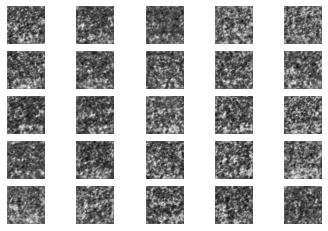

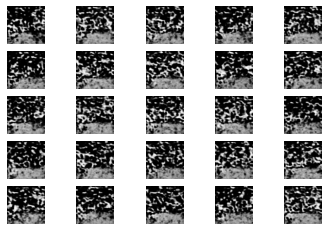

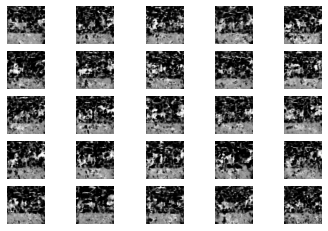

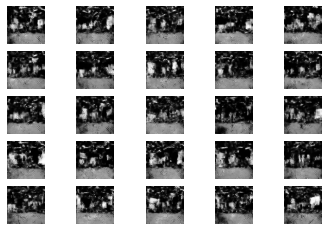

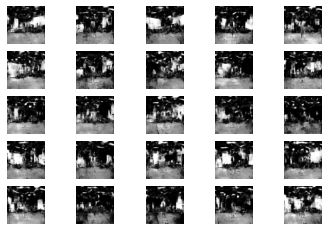

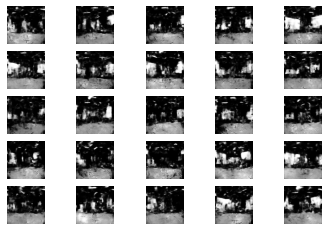

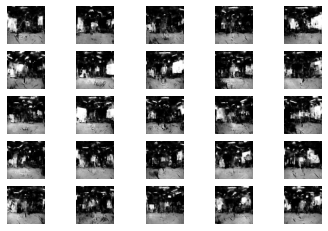

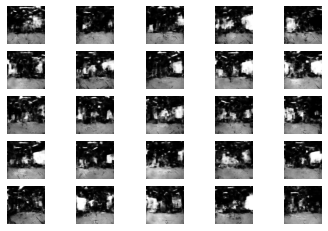

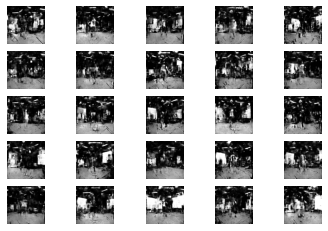

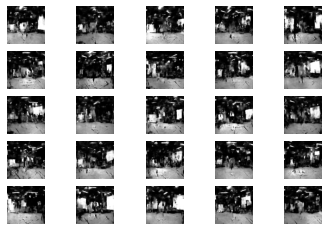

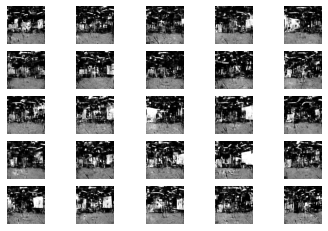

In [10]:
gan_train(2001, 32, 200)